## regression test

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set()
from patsy import dmatrix
import datetime as dt
import copy

In [2]:
taxi = pd.read_csv('train.csv')

datetime 형변환

In [3]:
datezero = dt.datetime(2016, 1, 1, 0, 0, 1) # 기준
datezero

datetime.datetime(2016, 1, 1, 0, 0, 1)

In [4]:
taxi['pickup_datetime'] = taxi['pickup_datetime'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
taxi['pick_date'] = taxi['pickup_datetime'].apply(lambda x: int((x - datezero).days))
taxi['pick_time'] = taxi['pickup_datetime'].apply(lambda x: int((x - datezero).seconds))
taxi['weekday'] = taxi['pickup_datetime'].apply(lambda x: int(x.weekday())) # 0 월

In [5]:
def haversine_np(lon1, lat1, lon2, lat2): #직선거리 구하는 함수
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [6]:
taxi['dist'] = haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'], taxi['dropoff_longitude'], taxi['dropoff_latitude'])
taxi['velo'] = taxi['dist']/taxi['trip_duration']*3600 #km/h

In [7]:
taxi2 = copy.deepcopy(taxi) # save

---

In [8]:
test = dmatrix("trip_duration + weekday + pick_date + pick_time  + dist", taxi, return_type ="dataframe" )
test.tail()

,Intercept,trip_duration,weekday,pick_date,pick_time,dist
1458639,1.0,778.0,4.0,98.0,48663.0,1.224311
1458640,1.0,655.0,6.0,9.0,27314.0,6.046037
1458641,1.0,764.0,4.0,112.0,25060.0,7.819693
1458642,1.0,373.0,1.0,4.0,57385.0,1.091878
1458643,1.0,198.0,1.0,95.0,53064.0,1.133330


In [9]:
real = test.loc[:, "trip_duration"] # 실제 정답 y
norm = []

In [10]:
features = " + ".join(list(test.columns)[3:])
features

'pick_date + pick_time + dist'

In [11]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4433.
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:13:39   Log-Likelihood:            -1.4554e+07
No. Observations:             1458644   AIC:                         2.911e+07
Df Residuals:                 1458640   BIC:                         2.911e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    455.6270     13.398     34.006      0.000     429.367     481.887
pick_date      0.5164      0.084      6.167      0.000       0.352       0.680
pick_time      0.0012      0.000      6.250      0.000       0.001       0.002
dist         115.6039      1.006    114.956      0.000     113.633     117.575
================================================================================
Omnibus:                  8312425.911   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2318004688590566.500
Skew:                         347.384   Prob(JB):                           0.00
Kurtosis:                  195295.414   Cond. No.                       1.73e+05
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

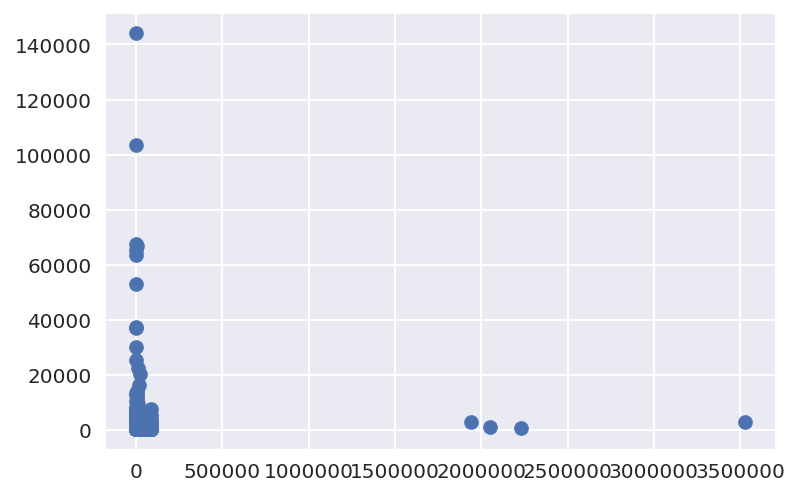

In [12]:
X = dmatrix("{}".format(features), taxi, return_type ="dataframe" )
predictions = result.predict(X) # 실제 데이터를 넣어 모형평가
norm = np.append(norm, np.linalg.norm(predictions-real)/len(X))
plt.scatter(real, predictions)
plt.show()

---

#### 예상했던 아웃라이어 제거

In [13]:
taxi = taxi[taxi['velo']<80] # 속도 80이상 삭제
taxi = taxi[taxi['trip_duration']<86400].reset_index(drop=True) # 24시간 이상 탑승 제거
# taxi = taxi[taxi['trip_duration']>30].reset_index(drop=True) # 30초 이하 탑승 제거 - 아마 잘못 눌렀으면 바로 껐을테고, 그럼 duration도 짧게 나올 것임. 

In [14]:
# new one
test = dmatrix("trip_duration + weekday + pick_date + pick_time  + dist", taxi, return_type ="dataframe" )
real = test.loc[:, "trip_duration"] #정답

In [15]:
features = " + ".join(list(test.columns)[3:])
features

'pick_date + pick_time + dist'

In [16]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary() # Log-Likelihood 값이 증가 - good

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 1.371e+04
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:14:09   Log-Likelihood:            -1.3807e+07
No. Observations:             1458406   AIC:                         2.761e+07
Df Residuals:                 1458402   BIC:                         2.761e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    376.5718      8.088     46.559      0.000     360.719     392.424
pick_date      0.6540      0.050     13.019      0.000       0.556       0.752
pick_time      0.0012      0.000     10.857      0.000       0.001       0.001
dist         132.4923      0.656    202.022      0.000     131.207     133.778
==============================================================================
Omnibus:                  3556867.032   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      30211642352.389
Skew:                          26.265   Prob(JB):                         0.00
Kurtosis:                     706.145   Cond. No.                     1.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
X = dmatrix("{}".format(features), taxi, return_type ="dataframe" )
predictions = result.predict(X)
norm = np.append(norm, np.linalg.norm(predictions-real)/len(X))

## weekday +

In [18]:
features = " + ".join(list(test.columns)[2:])
features

'weekday + pick_date + pick_time + dist'

In [19]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 1.029e+04
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:14:11   Log-Likelihood:            -1.3807e+07
No. Observations:             1458406   AIC:                         2.761e+07
Df Residuals:                 1458401   BIC:                         2.761e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    387.3460      9.299     41.657      0.000     369.121     405.571
weekday       -3.1244      1.330     -2.349      0.019      -5.732      -0.517
pick_date      0.6523      0.050     12.984      0.000       0.554       0.751
pick_time      0.0012      0.000     10.621      0.000       0.001       0.001
dist         132.5032      0.656    202.034      0.000     131.218     133.789
==============================================================================
Omnibus:                  3556924.504   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      30214905881.787
Skew:                          26.266   Prob(JB):                         0.00
Kurtosis:                     706.183   Cond. No.                     2.01e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

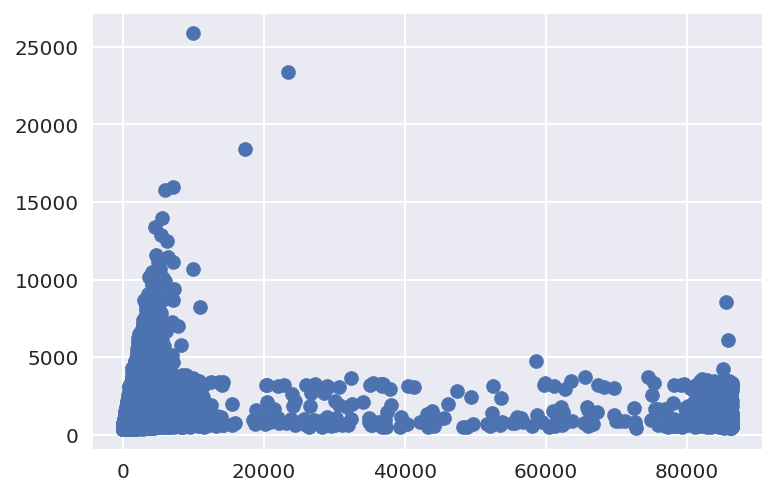

In [20]:
X = dmatrix("{}".format(features), taxi, return_type ="dataframe" )
predictions = result.predict(X)
norm = np.append(norm, np.linalg.norm(predictions-real)/len(X))
plt.scatter(real, predictions)
plt.show()

In [21]:
features = " + ".join(list(test.columns)[3:])
features

'pick_date + pick_time + dist'

In [22]:
# weekday를 카테고리 형태로 입력
model =  sm.OLS.from_formula("trip_duration ~ C(weekday) + {}".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     4615.
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:14:50   Log-Likelihood:            -1.3807e+07
No. Observations:             1458406   AIC:                         2.761e+07
Df Residuals:                 1458396   BIC:                         2.761e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           309.9062     10.649     29.103      0.000     289.035     330.777
C(weekday)[T.1.0]    93.0156     10.023      9.280      0.000      73.370     112.661
C(weekday)[T.2.0]   106.2401      9.939     10.690      0.000      86.761     125.719
C(weekday)[T.3.0]   126.2413      9.848     12.819      0.000     106.940     145.542
C(weekday)[T.4.0]   118.4083      9.799     12.084      0.000      99.203     137.614
C(weekday)[T.5.0]    59.8866      9.830      6.092      0.000      40.620      79.153
C(weekday)[T.6.0]    -9.5470     10.139     -0.942      0.346     -29.420      10.326
pick_date             0.6489      0.050     12.910      0.000       0.550       0.747
pick_time             0.0011      0.000      9.569      0.000       0.001       0.001
dist                132.8178      0.656    202.438      0.000     131.532     134.104
==============================================================================
Omnibus:                  3557495.213   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      30247278871.678
Skew:                          26.276   Prob(JB):                         0.00
Kurtosis:                     706.560   Cond. No.                     4.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

# Strict

In [23]:
taxi2 = taxi2[taxi2['trip_duration']<7200] # 2시간이상 탑승 제거
taxi2 = taxi2[taxi2['dist']<180] #180km 이상 이동 제거
taxi = taxi2[taxi2['velo']<60].reset_index(drop=True) # 속도 60이상 삭제

In [24]:
# new one
test = dmatrix("trip_duration + weekday + pick_date + pick_time  + dist", taxi, return_type ="dataframe" ) 
real = test.loc[:, "trip_duration"] #정답

In [25]:
features = " + ".join(list(test.columns)[3:])
features

'pick_date + pick_time + dist'

In [26]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 7.275e+05
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:14:53   Log-Likelihood:            -1.0837e+07
No. Observations:             1455708   AIC:                         2.167e+07
Df Residuals:                 1455704   BIC:                         2.167e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    278.7269      1.071    260.134      0.000     276.627     280.827
pick_date      0.5951      0.007     89.459      0.000       0.582       0.608
pick_time      0.0012   1.49e-05     82.163      0.000       0.001       0.001
dist         128.7310      0.087   1471.734      0.000     128.560     128.902
==============================================================================
Omnibus:                   610353.344   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7458732.428
Skew:                           1.684   Prob(JB):                         0.00
Kurtosis:                      13.566   Cond. No.                     1.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
X = dmatrix("{}".format(features), taxi, return_type ="dataframe" )
predictions = result.predict(X)
norm = np.append(norm, np.linalg.norm(predictions-real)/len(X))

In [28]:
norm

array([ 4.31690768,  2.58995573,  2.58995084,  0.34296385])

# weekday +

In [29]:
features = " + ".join(list(test.columns)[2:])
features

'weekday + pick_date + pick_time + dist'

In [30]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data=test)
result = model.fit()
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 5.487e+05
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:14:54   Log-Likelihood:            -1.0834e+07
No. Observations:             1455708   AIC:                         2.167e+07
Df Residuals:                 1455703   BIC:                         2.167e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    321.0422      1.230    261.090      0.000     318.632     323.452
weekday      -12.2726      0.176    -69.780      0.000     -12.617     -11.928
pick_date      0.5885      0.007     88.612      0.000       0.576       0.602
pick_time      0.0011   1.49e-05     76.149      0.000       0.001       0.001
dist         128.7741      0.087   1474.649      0.000     128.603     128.945
==============================================================================
Omnibus:                   608755.686   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7501378.692
Skew:                           1.675   Prob(JB):                         0.00
Kurtosis:                      13.604   Cond. No.                     2.01e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

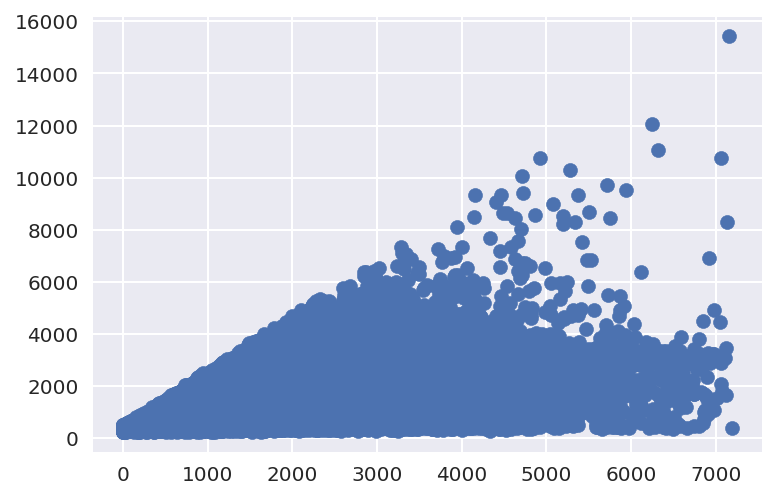

In [31]:
X = dmatrix("{}".format(features), taxi, return_type ="dataframe" )
predictions = result.predict(X)
norm = np.append(norm, np.linalg.norm(predictions-real)/len(X))
plt.scatter(real, predictions)
plt.show()

In [32]:
features = " + ".join(list(test.columns)[3:])
features

'pick_date + pick_time + dist'

In [33]:
# weekday를 카테고리 형태로 입력
model =  sm.OLS.from_formula("trip_duration ~ C(weekday) + {}".format(features), data=test)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 2.503e+05
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:15:34   Log-Likelihood:            -1.0823e+07
No. Observations:             1455708   AIC:                         2.165e+07
Df Residuals:                 1455698   BIC:                         2.165e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           244.5975      1.397    175.064      0.000     241.859     247.336
C(weekday)[T.1.0]    72.2936      1.315     54.986      0.000      69.717      74.870
C(weekday)[T.2.0]    97.1238      1.304     74.504      0.000      94.569      99.679
C(weekday)[T.3.0]   104.3622      1.292     80.793      0.000     101.830     106.894
C(weekday)[T.4.0]    81.6938      1.285     63.558      0.000      79.175      84.213
C(weekday)[T.5.0]     2.4740      1.290      1.918      0.055      -0.053       5.001
C(weekday)[T.6.0]   -60.4684      1.330    -45.459      0.000     -63.075     -57.861
pick_date             0.5838      0.007     88.544      0.000       0.571       0.597
pick_time             0.0010   1.48e-05     68.591      0.000       0.001       0.001
dist                129.0671      0.087   1488.895      0.000     128.897     129.237
==============================================================================
Omnibus:                   605764.391   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7671405.643
Skew:                           1.656   Prob(JB):                         0.00
Kurtosis:                      13.747   Cond. No.                     4.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

[ 4.31690768  2.58995573  2.58995084  0.34296385  0.34239169]


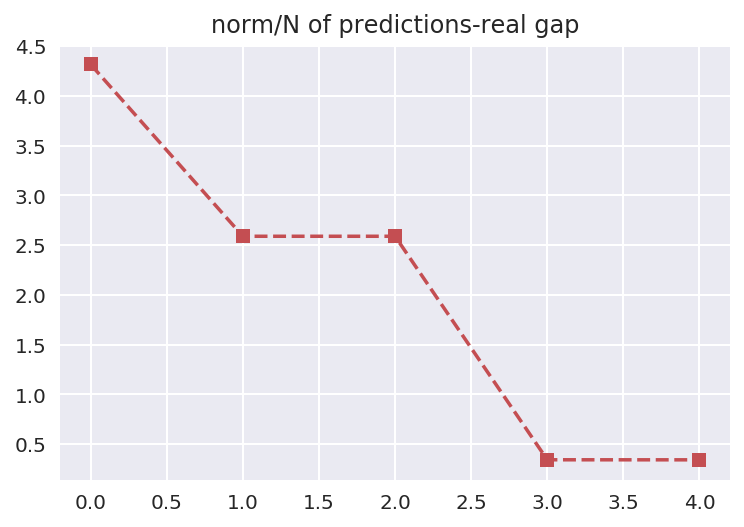

In [34]:
plt.plot(norm,'--sr')
plt.title("norm/N of predictions-real gap")
print(norm)
plt.show()

---

## Outlier 제거

In [35]:
influence = result.get_influence()
hat = influence.hat_matrix_diag
# plt.stem(hat) 140만개는 불가능....
# plt.show()

In [36]:
# sm.graphics.influence_plot(result, plot_alpha=0.3) # 버블크기로 표시
# plt.show()

In [37]:
# fox_cr = 4 / (len(tx) - len(test.columns) - 1)
# cooks_d2, pvals = influence.cooks_distance
# idx = np.where(cooks_d2 > fox_cr)[0]
# idx # outlier 위치 
# print(len(idx))
# tx.drop(idx)
# tx.reset_index(drop=True, inplace=True)